# Deep Reinforcement Learning for Supply Chain and Price Optimization

This notebook demonstrates how pricing decisions can be optimized using reinforcement learning (RL).

### Use Case
We assume a complex market environment that responds on price changes in a non-linear way. For example, the market may have memory effects (response is dependent on a price history). Our goal is to learn the revenue/profit-maximizing price management policy.

### Prototype: Approach and Data
Our assumptions about the market mean that basic price optimization models (e.g. ones that assume a log-linear response) are not applicable. A generic solution can be created using simulation-based optimization.
 
We define a simulation environment with a complex price-demand function. We then use the DQN algorithm to learn a policy that jointly optimizes the price schedule for several time steps ahead. We provide two implementation approaches: hand-coded DQN based on [2] and off-the-shelf RLLib DQN implementation. We also provide diagnostics functions that help to interpret the learned policy.

### Usage and Productization
The RL-based approach can be used in dynamic environments such as online marketplaces. However, productization of complete RL-based solutions (beyond bandit algorithms) is challenging because the learned policies tend to be highly irregular and learning process is sample-inefficient. 

### References
1. Kemmer L., et al. -- Reinforcement learning for supply chain optimization, 2018
2. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [1]:
#
# Imports and settings
#
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('seaborn-white')
import pandas as pd
from matplotlib import animation, rc
plt.rcParams.update({'pdf.fonttype': 'truetype'})

from qbstyles import mpl_style
mpl_style(dark=False)


# Environment: Asymmetric Price Response and Hi-Lo Pricing

Traditional price optimization assumes a simple known parametric price-response function. Optimization under such an assumption is relatively straightforward, even in case of inventory constraints or other factors. Many basic formulations can be solved analytically, and many others can be solved numerically. The challenge is typically in estimating the price-response function, not in the optimization part.

In some cases, however, optimization also becomes a challenge. This section introduces an example of a price-demand function with temporal dependencies. The optimal price schedule for such a functon has a sawtooth shape.

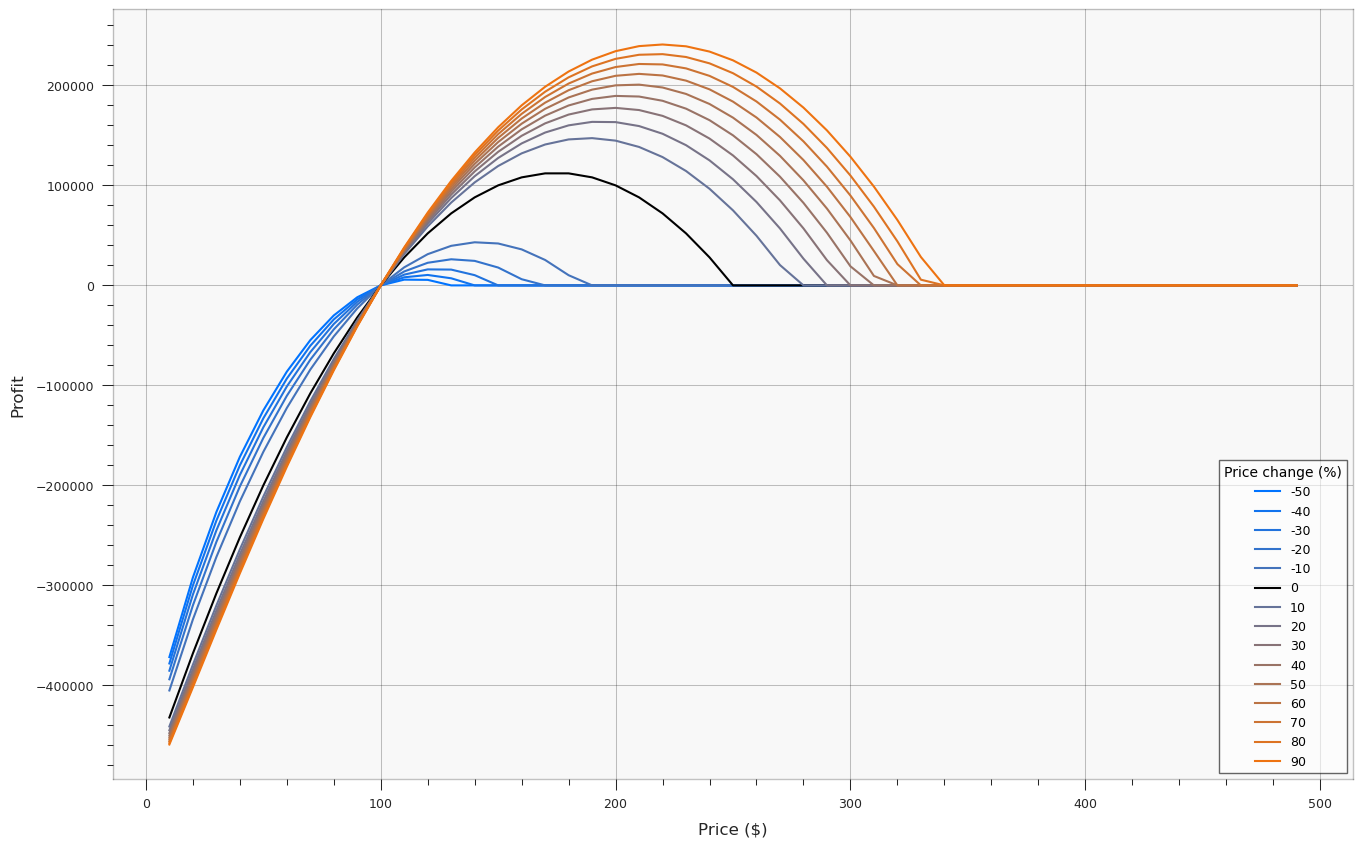

In [2]:
## Environment simulator
def plus(x):
    return 0 if x < 0 else x

def minus(x):
    return 0 if x > 0 else -x

def shock(x):
    return np.sqrt(x)

# Demand at time step t for current price p_t and previous price p_t_1
def q_t(p_t, p_t_1, q_0, k, a, b):
    return plus(q_0 - k*p_t - a * shock(plus(p_t - p_t_1)) + b * shock(minus(p_t - p_t_1)))

# Profit at time step t
def profit_t(p_t, p_t_1, q_0, k, a, b, unit_cost):
    return q_t(p_t, p_t_1, q_0, k, a, b)*(p_t - unit_cost) 

# Total profit for price vector p over len(p) time steps
def profit_total(p, unit_cost, q_0, k, a, b):
    return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost), range(len(p))))

## Environment parameters
T = 20
price_max = 500
price_step = 10
q_0 = 5000
k = 20
unit_cost = 100
a_q = 300
b_q = 100

## Partial bindings for readability
def profit_t_response(p_t, p_t_1):
    return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost)

def profit_response(p):
    return profit_total(p, unit_cost, q_0, k, a_q, b_q)

## Visualize price-demand functions
price_grid = np.arange(price_step, price_max, price_step)
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) )
for i in range(len(price_grid)):
    for j in range(len(price_change_grid)):
        profit_map[i,j] = profit_t_response(price_grid[i], price_grid[i]*price_change_grid[j])

plt.figure(figsize=(16, 10))
for i in range(len(price_change_grid)):
    if math.isclose(price_change_grid[i], 1.0):
        color = 'black'
    else:
        p_norm = (price_change_grid[i]-0.5)/1.5
        color = (p_norm, 0.45, 1 - p_norm)
    plt.plot(price_grid, profit_map[:, i], c=color)
plt.xlabel("Price ($)")
plt.ylabel("Profit")
plt.legend(np.int_(np.round((price_change_grid - 1)*100)), loc='lower right', title="Price change (%)", fancybox=False, framealpha=0.6)
plt.grid(True)

# Solution: Baselines

In this section, we establish two baselines using basic optimization techniques:
*   Optimal constant price
*   Optimal price schedule using sequenctial greedy search (optimize prices one by one) 



In [3]:
# Find optimal constant price

profits = np.array([ profit_response(np.repeat(p, T)) for p in price_grid ])
p_idx = np.argmax(profits)
price_opt_const = price_grid[p_idx]

print(f'Optimal price is {price_opt_const}, achieved profit is {profits[p_idx]}')

Optimal price is 170, achieved profit is 2352000.0


[170 490 220 190 180 170 490 220 190 180 170 490 220 190 180 170 490 220
 190 180]
Achieved profit is 2903637.2631194014


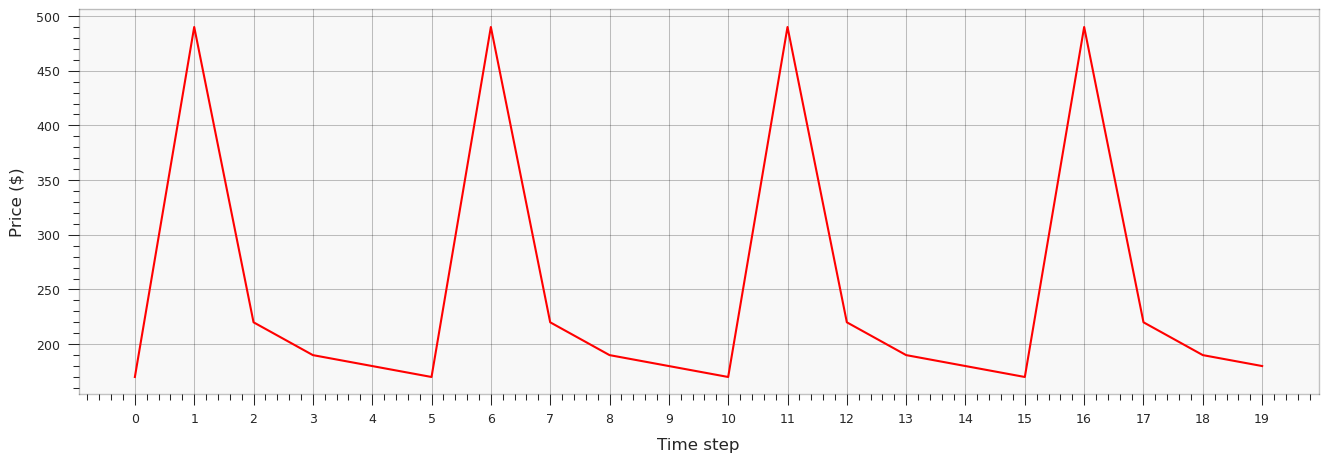

In [4]:
# Find optimal sequence of prices using greedy search

def find_optimal_price_t(p_baseline, price_grid, t):
    p_grid = np.tile(p_baseline, (len(price_grid), 1))
    p_grid[:, t] = price_grid
    profit_grid = np.array([ profit_response(p) for p in p_grid ])
    return price_grid[ np.argmax(profit_grid) ]

p_opt = np.repeat(price_opt_const, T)
for t in range(T):
    price_t = find_optimal_price_t(p_opt, price_grid, t)
    p_opt[t] = price_t

print(p_opt)
print(f'Achieved profit is {profit_response(p_opt)}')

plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Price ($)")
plt.xticks(np.arange(T))
plt.plot(np.arange(T), p_opt, c='red')

# Visualization Functions

This section defines several auxillary visualization function used to visualize the results of the optimization, as well as some debuggin information.

In [6]:
# Visualization functions

from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label

output_notebook()

def plot_return_trace(returns, smoothing_window=10, range_std=2):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    plt.plot(ma, c='blue', alpha=1.00, linewidth=1)
    plt.fill_between(mstd.index, ma-range_std*mstd, ma+range_std*mstd, color='blue', alpha=0.2)
    plt.show()

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
    plt.figure(fig_number);
    plt.xlabel("Time step");
    plt.ylabel("Price ($)");
    plt.xticks(range(T))
    plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c = 'k', alpha = 0.05)
    return plt.plot(range(T), np.array(p_trace[-(last_highlights+1):-1]).T, c = 'red', alpha = 0.5, linewidth=2)

def bullet_graph(data, labels=None, bar_label=None, axis_label=None,
                size=(5, 3), palette=None, bar_color="black", label_color="gray"):
    stack_data = np.stack(data[:,2])

    cum_stack_data = np.cumsum(stack_data, axis=1)
    h = np.max(cum_stack_data) / 20

    fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)

    for idx, item in enumerate(data):

        if len(data) > 1:
            ax = axarr[idx]

        ax.set_aspect('equal')
        ax.set_yticklabels([item[0]])
        ax.set_yticks([1])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        prev_limit = 0
        for idx2, lim in enumerate(cum_stack_data[idx]):
            ax.barh([1], lim - prev_limit, left=prev_limit, height=h, color=palette[idx2])
            prev_limit = lim
        rects = ax.patches
        ax.barh([1], item[1], height=(h / 3), color=bar_color)

    if labels is not None:
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                -height * .4,
                label,
                ha='center',
                va='bottom',
                color=label_color)
            
    if bar_label is not None:
        rect = rects[0]
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width(),
            -height * .1,
            bar_label,
            ha='center',
            va='bottom',
            color='white')
    if axis_label:
        ax.set_xlabel(axis_label)
    fig.subplots_adjust(hspace=0)

Loading BokehJS ...

Episode 980 of 1000 (98.00%)


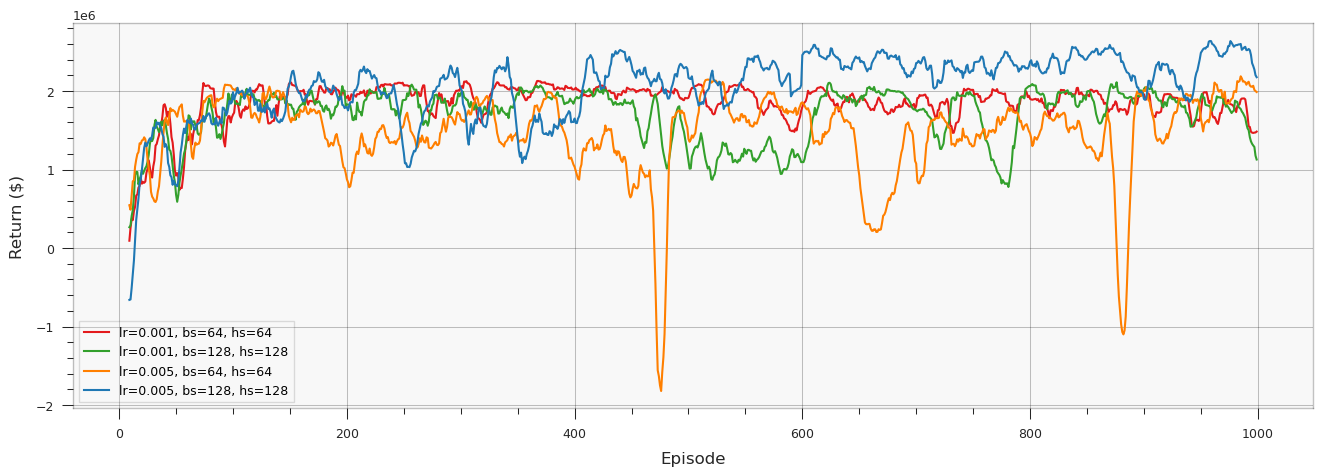

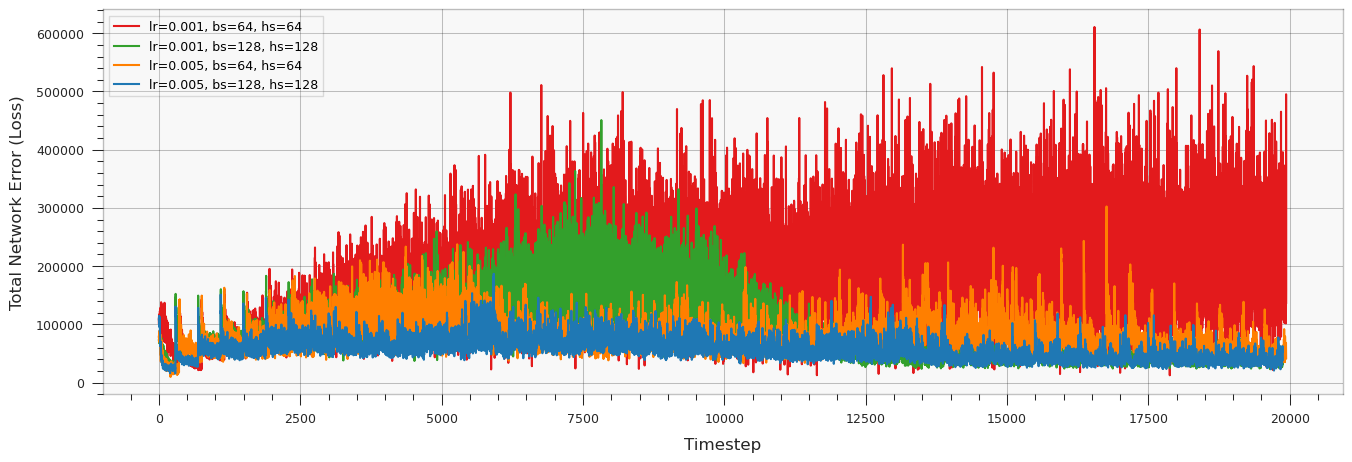

In [8]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# A cyclic buffer of bounded size that holds the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class PolicyNetworkDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetworkDQN, self).__init__()
        layers = [
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        q_values = self.model(x)
        return q_values  

class AnnealedEpsGreedyPolicy(object):
    def __init__(self, eps_start=0.9, eps_end=0.05, eps_decay=400):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.steps_done = 0

    def select_action(self, q_values):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            return np.argmax(q_values)
        else:
            return random.randrange(len(q_values))

def plot_return_trace(returns_dict):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    for label, returns in returns_dict.items():
        returns_df = pd.Series(returns)
        ma = returns_df.rolling(window=10).mean()
        plt.plot(ma, label=label)
    plt.legend()
    plt.grid(True)

def plot_learning_curve(losses_dict):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Timestep")
    plt.ylabel("Total Network Error (Loss)")
    for label, losses in losses_dict.items():
        plt.plot(losses, label=label)
    plt.legend()
    plt.grid(True)

def env_initial_state():
    return np.repeat(0, 2*T)

def env_step(t, state, action):
    next_state = np.repeat(0, len(state))
    next_state[0] = price_grid[action]
    next_state[1:T] = state[0:T-1]
    next_state[T+t] = 1
    reward = profit_t_response(next_state[0], next_state[1])
    return next_state, reward

def to_tensor(x):
    return torch.from_numpy(np.array(x).astype(np.float32))

def to_tensor_long(x):
    return torch.tensor([[x]], device=device, dtype=torch.long)

# Set the hyperparameters
hyperparameter_combinations = [
    {'lr': 0.001, 'batch_size': 64, 'hidden_size': 64},
    {'lr': 0.001, 'batch_size': 128, 'hidden_size': 128},
    {'lr': 0.005, 'batch_size': 64, 'hidden_size': 64},
    {'lr': 0.005, 'batch_size': 128, 'hidden_size': 128},
]

num_episodes = 1000
T = 20
price_max = 500
price_step = 10
q_0 = 5000
k = 20
unit_cost = 100
a_q = 300
b_q = 100
price_grid = np.arange(price_step, price_max, price_step)

# Define profit functions
def profit_t(p_t, p_t_1, q_0, k, a, b, unit_cost):
    return q_t(p_t, p_t_1, q_0, k, a, b) * (p_t - unit_cost) 

def q_t(p_t, p_t_1, q_0, k, a, b):
    def plus(x):
        return 0 if x < 0 else x

    def minus(x):
        return 0 if x > 0 else -x

    def shock(x):
        return np.sqrt(x)

    return plus(q_0 - k * p_t - a * shock(plus(p_t - p_t_1)) + b * shock(minus(p_t - p_t_1)))

def profit_t_response(p_t, p_t_1):
    return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost)

# Run training for different hyperparameter combinations
return_traces = {}
losses_traces = {}

for params in hyperparameter_combinations:
    label = f"lr={params['lr']}, bs={params['batch_size']}, hs={params['hidden_size']}"
    print(f"Training with {label}")
    
    policy_net = PolicyNetworkDQN(2*T, len(price_grid), hidden_size=params['hidden_size']).to(device)
    target_net = PolicyNetworkDQN(2*T, len(price_grid), hidden_size=params['hidden_size']).to(device)
    optimizer = optim.AdamW(policy_net.parameters(), lr=params['lr'])
    policy = AnnealedEpsGreedyPolicy()
    memory = ReplayMemory(10000)

    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    return_trace = []
    losses = []  # To store the loss values
    for i_episode in range(num_episodes):
        state = env_initial_state()
        reward_trace = []
        for t in range(T):
            # Select and perform an action
            with torch.no_grad():
                q_values = policy_net(to_tensor(state))
            action = policy.select_action(q_values.detach().numpy())

            next_state, reward = env_step(t, state, action)

            # Store the transition in memory
            memory.push(to_tensor(state), 
                        to_tensor_long(action), 
                        to_tensor(next_state) if t != T - 1 else None, 
                        to_tensor([reward]))

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            if len(memory) >= params['batch_size']:
                transitions = memory.sample(params['batch_size'])
                batch = Transition(*zip(*transitions))

                non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
                non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

                state_batch = torch.stack(batch.state)
                action_batch = torch.cat(batch.action)
                reward_batch = torch.stack(batch.reward)

                state_action_values = policy_net(state_batch).gather(1, action_batch)

                next_state_values = torch.zeros(params['batch_size'], device=device)
                next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

                expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)  

                loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                for param in policy_net.parameters():
                    param.grad.data.clamp_(-1, 1)
                optimizer.step()

                losses.append(loss.item())  # Track the loss

            reward_trace.append(reward)

        return_trace.append(sum(reward_trace))

        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
            clear_output(wait=True)
            print(f'Episode {i_episode} of {num_episodes} ({i_episode/num_episodes*100:.2f}%)')

    return_traces[label] = return_trace
    losses_traces[label] = losses

# Plot the return traces
plot_return_trace(return_traces)

# Plot the learning curves
plot_learning_curve(losses_traces)
